<a href="https://colab.research.google.com/github/dscoool/chungbuk/blob/main/tensorflow_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텐서플로우 고급 예제

아래 코드를 실행하면서 tensorflow와 이미지 분류기에 대한

감을 익혀 봅시다!!







먼저 프로그램에 텐서플로 라이브러리를 임포트합니다.

In [2]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model


[MNIST 데이터셋](https://brunch.co.kr/@minwoo/25) 을 로드하여 준비합니다.

MNIST 데이터셋: NIST(Institute of Standards and Technology, 미국 국립표준기술연구소)의 손으로 쓴 글자 데이터셋에서 숫자만 따로 뽑아낸 데이터셋입니다.

0부터 255 사이의 값을 가지는 흑백 이미지, 28x28 사이즈, 7만 개 이미지(6만 개 트레이닝 셋, 1만 개 테스트 셋)로 구성되어있습니다. 

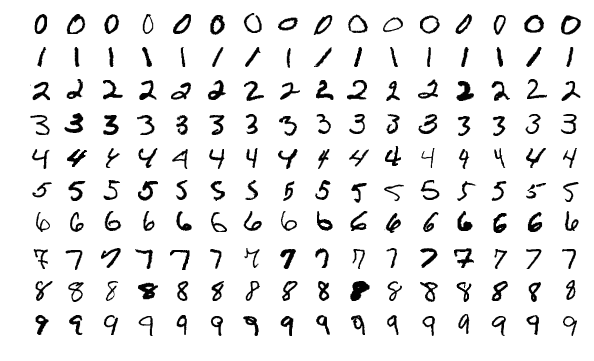

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 채널 차원을 추가합니다.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


11490434/11490434 [==============================] - 0s 0us/step


f.data를 사용하여 데이터셋을 섞고 배치를 만듭니다:



In [5]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


케라스(Keras)의 모델 서브클래싱(subclassing) API 를 사용하여 tf.keras 모델을 만듭니다:

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


케라스(Keras)의  [모델 서브클래싱(subclassing) API](https://www.tensorflow.org/guide/keras?hl=ko#model_subclassing) 를 사용하여 [tf.keras 모델](https://www.tensorflow.org/api_docs/python/tf/keras?hl=ko)을 만듭니다:

In [7]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = MyModel()


훈련에 필요한 옵티마이저(optimizer)와 손실 함수를 선택합니다:



In [8]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()


모델의 손실과 성능을 측정할 지표를 선택합니다. 에포크가 진행되는 동안 수집된 측정 지표를 바탕으로 최종 결과를 출력합니다.

In [9]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


[tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape?hl=ko) 를 사용하여 모델을 훈련합니다:

In [10]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)


이제 모델을 테스트합니다:

In [12]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = '에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))
                         
'''
WARNING:tensorflow:Entity <function train_step at 0x7f24a41c2b70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Str'
WARNING: Entity <function train_step at 0x7f24a41c2b70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Str'
WARNING:tensorflow:Layer my_model is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

WARNING:tensorflow:Entity <bound method MyModel.call of <__main__.MyModel object at 0x7f24a14b7908>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
WARNING: Entity <bound method MyModel.call of <__main__.MyModel object at 0x7f24a14b7908>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
WARNING:tensorflow:Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7f24a13f4840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'
WARNING: Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7f24a13f4840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Num'
WARNING:tensorflow:Entity <bound method MyModel.call of <__main__.MyModel object at 0x7f24a14b7908>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
WARNING: Entity <bound method MyModel.call of <__main__.MyModel object at 0x7f24a14b7908>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
WARNING:tensorflow:Entity <function test_step at 0x7f24a41c2bf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Str'
WARNING: Entity <function test_step at 0x7f24a41c2bf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: module 'gast' has no attribute 'Str'
WARNING:tensorflow:Entity <bound method MyModel.call of <__main__.MyModel object at 0x7f24a14b7908>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
WARNING: Entity <bound method MyModel.call of <__main__.MyModel object at 0x7f24a14b7908>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
WARNING:tensorflow:Entity <bound method MyModel.call of <__main__.MyModel object at 0x7f24a14b7908>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
WARNING: Entity <bound method MyModel.call of <__main__.MyModel object at 0x7f24a14b7908>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
에포크: 1, 손실: 0.1347680389881134, 정확도: 95.9366683959961, 테스트 손실: 0.05350242182612419, 테스트 정확도: 98.12999725341797
에포크: 2, 손실: 0.0896165519952774, 정확도: 97.27583312988281, 테스트 손실: 0.054728906601667404, 테스트 정확도: 98.13500213623047
에포크: 3, 손실: 0.06729747354984283, 정확도: 97.9477767944336, 테스트 손실: 0.05539105087518692, 테스트 정확도: 98.16667175292969
에포크: 4, 손실: 0.05394642427563667, 정확도: 98.34916687011719, 테스트 손실: 0.055290184915065765, 테스트 정확도: 98.23750305175781
에포크: 5, 손실: 0.04513656720519066, 정확도: 98.60933685302734, 테스트 손실: 0.05616115406155586, 테스트 정확도: 98.27400207519531
'''


에포크: 1, 손실: 0.1337968409061432, 정확도: 95.99166870117188, 테스트 손실: 0.06267604976892471, 테스트 정확도: 98.02999877929688
에포크: 2, 손실: 0.08763353526592255, 정확도: 97.35916900634766, 테스트 손실: 0.0599505752325058, 테스트 정확도: 98.04999542236328
에포크: 3, 손실: 0.06582480669021606, 정확도: 98.00111389160156, 테스트 손실: 0.056744322180747986, 테스트 정확도: 98.18999481201172
에포크: 4, 손실: 0.0524919256567955, 정확도: 98.40583038330078, 테스트 손실: 0.05796533077955246, 테스트 정확도: 98.22999572753906


훈련된 이미지 분류기는 이 데이터셋에서 약 98%의 정확도를 달성합니다. 더 자세한 내용은 [TensorFlow 튜토리얼](https://www.tensorflow.org/tutorials/)을 참고해 주십시오.